In [2]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import *
from metpy.calc import lat_lon_grid_deltas
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


# Goal: Estimate acceleration profile $\hat{m}$ Using Newton-Raphson to compensate for distortion between similar point cloud

Through the first order Taylor approximation we define: 

$\mathbf{h}(\hat{m})$ as the means of voxel centers in cloud $j$ passed through the distortion operator $\mathbb{C}$ according to estimated motion profile $\hat{m}$. 

$\mathbf{H}$ is the Jacobian of $\mathbf{h}$, which is multiplied by a linear correction factor $\delta m$.

$    y_i = \mathbf{h}(\hat{m}) + \mathbf{H} \delta m $


In [3]:
# load point cloud
# # no distortion
# old_cloud =  np.load("sample_data/paper_figures/case1/raw_frame_0.npy")
# # m_hat = np.array([0., 0., 0., 0., 0., 0.0]) #actual motion
# m_hat = np.array([-3., 0., 0., 0., 0., 0.1]) #test wrap around

# # movement in x
# old_cloud =  np.load("sample_data/paper_figures/case2/raw_frame_3.npy") 
# m_hat = np.array([3, 0, 0., 0., 0., 0])
# # m_hat = np.array([3, 0, 0., 0., 0., -0.2]) #FOR DEBUG-- deform just a little
# gt =  np.load("sample_data/paper_figures/case2/base_vel_2.npy")

# movement in x, y, & yaw
old_cloud =  np.load("sample_data/paper_figures/case3/raw_frame_1.npy") 
m_hat = np.array([3, -1, 0., 0., 0., -1])
# m_hat = np.array([3, -1, 0.1, 0.1, 0.05, -1]) #FOR DEBUG-- deform a little extra
gt =  np.load("sample_data/paper_figures/case3/base_vel_2.npy")
# print(gt) 

# period_lidar = 1
# t_scale = (2*np.pi)/(-m_hat[-1] + (2*np.pi/period_lidar))
# print(t_scale)
# m_hat = m_hat*t_scale
# # m_hat[-1] = m_hat[-1]*t_scaled
# print(m_hat)


#downsample
old_cloud = old_cloud[::5,:]

In [4]:
from remove_motion_basic import linear_correction_old as lc 

new_cloud = lc(old_cloud, m_hat)
# undistorted = lc(new_cloud, -m_hat)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
# disp.append(Points(undistorted, c = "#CB2314"))
# disp.append(Points(old_cloud, c = "#CB2314"))
disp.append(Points(new_cloud, c = "#3F5151"))
plt.show(disp, "test viz")
ViewInteractiveWidget(plt.window)

/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Analytically calculating derivatives with SymPy

In [6]:
from sympy import *

x, y, z = symbols('x y z')

init_printing(use_unicode=True)

In [7]:
#sovles for the derivative
ans1 = diff(cos(x), x)
print(ans1)

#creates an unevaluated derivative
ans2 = Derivative(cos(x), x)
print(ans2)

-sin(x)
Derivative(cos(x), x)


In [8]:
ans3 = integrate(sin((x+1)/2)*(cos(x)-sin(x))**2, x)
# print(latex(ans3)) #-> converts to LaTeX so I don't have to re-copy everything 

integrate(sin((x+1)/2)*(cos(x)-sin(x))**2, x)


In [9]:
a = Matrix([[10*x, 2], 
            [3, 4*x]])
# A = integrate(a**2)
# print(latex(A))
integrate(a**2)

⎡     3                   ⎤
⎢100⋅x                2   ⎥
⎢────── + 6⋅x     14⋅x    ⎥
⎢  3                      ⎥
⎢                         ⎥
⎢                  3      ⎥
⎢       2      16⋅x       ⎥
⎢   21⋅x       ───── + 6⋅x⎥
⎣                3        ⎦

In [10]:
b = Matrix([[x + 1, 2*y],
            [3*x**2*y, 3 + x + y**2]])
diff(b, y, x)

⎡ 0   0⎤
⎢      ⎥
⎣6⋅x  0⎦

# Derive Jacobain H

### $\mathbf{H} \in \mathbb{R}^{4N \times 6} $

### $\mathbf{H} = 
\begin{bmatrix}
^{(n)}H_{x} ~ ^{(n)}H_{y} ~ ^{(n)}H_{z} ~ ^{(n)}H_{\phi} ~ ^{(n)}H_{\theta} ~ ^{(n)}H_{\psi}
\end{bmatrix}$

### $ ^{(n)}\mathbf{H}_x =  \frac{\delta{\mathbf{C}}}{\delta x} ~ ^{(n)}y_j \in \mathbb{R}^{4 \times 1}$

### Here $^{(n)}y_j$ refers to distribution mean from scan j inside voxel n, denoted in homogenous coordinates

$[x, y, z] \rightarrow [x, y, z, 1] $ 

<!-- <span style="color:red"> TODO: figure out if I need to use homogeneous coordinates for $y_j$ </span> -->

# Calculate correction  function $\mathbf{C}$ 

## $\mathbf{C}(\hat{m}) = T_{\text{rect}}(M(\hat{m})) \in \mathbb{R}^{4 \times 4} $

Here, the rectifying transformation $T_{\text{rect}}$ for each point in $y_j$ depends on scaled values of $\hat{m}$ which are concatenated to form matrix $M$. Since points are stored in the order they are recieved and are somewhat even spread throughout the scene, we can approximate $M$ through a simple linspace matrix without needing to transform to a spherical representation. $t_{\text{scale}}$ is a scaling parameter to normalize the turn rate of the sensor in the presence of composite yaw rotation.

## $
M = \bigg{(} \{ r: r = t_{\text{scale}} \frac{p}{P}, p \in \{ 0, 1, ..., P \} \} \bigg{)} \hat{m}
\in \mathbb{R}^{P \times 6}
% \begin{bmatrix}
% 1 & 1 & 1 & 1 
% \end{bmatrix}
$

## $t_{\text{scale}} = \frac{2\pi}{-\psi + \omega_{\text{LIDAR}} } $ 


My old way of "unwinding" was acomplished by converting the point cloud to spherical coordinates, rescaling the yaw angle, and then converting back to Cartesian 

<!-- ## $y_{j, \text{unwound}} =
\text{s2c} \bigg{(} \text{c2s}(y_{j})
\begin{bmatrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & \psi_{\text{rect}}
\end{bmatrix} \bigg{)}$
 -->
Unfortunately, c2s() is a nonlinear operation so it makes things a little tricky when we need to do everything via linear algebra

<!-- ## $ \text{c2s}(y_j) = 
\begin{bmatrix}
x_1 & y_1 & z_1 \\
x_2 & y_2 & z_2 \\
 & \vdots &
\end{bmatrix}
\rightarrow
\begin{bmatrix}
r_1 & \phi_1 & \theta_1 \\
r_2 & \phi_2 & \theta_2 \\
r_3 & \phi_3 & \theta_3
\end{bmatrix}
$
 -->
<!-- ### GPT:
lol it really got this wro

$ ^{(n)}y_j = \begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
$

$ B = \begin{bmatrix}
\text{sin}(\theta) ~ \text{cos}(\phi) & \text{cos}(\theta) ~ \text{cos}(\phi) & -\text{sin}(\phi) \\
\text{sin}(\theta)\text{sin}(\phi) & \text{cos}(\theta)\text{sin}(\phi) & \text{cos}(\phi) \\
\text{cos}(\theta) & -\text{sin}(\theta) & 0
\end{bmatrix}
$

$B ~ ^{(n)}y_j = ^{(n)}y_{j, \text{spherical}} $ -->


<!-- Putting everything together:

 $
\mathbb{C}(y_j, \hat{m}) =
M ~ T_{\text{rect}} \bigg{[} \text{s2c} \bigg{(} \text{c2s}(y_{j})
\begin{bmatrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & \psi_{\text{rect}}
\end{bmatrix} \bigg{)},
\begin{bmatrix}
    1 \\
    \vdots 
\end{bmatrix}
\bigg{]}^T$
 -->

In [11]:
period_lidar = 1
m_hat = np.array([3, 0, 0., 0., 0., -0.5])
t_scale = (2*np.pi)/(-m_hat[-1] + (2*np.pi/period_lidar))
# print(t_scale)
lsvec = np.linspace(0,t_scale, 100)

print(np.shape(m_hat))
M = m_hat * np.array([lsvec, lsvec, lsvec, lsvec, lsvec, lsvec]).T
# print(np.shape(M))
# print(M)

(6,)


## Get transform $T_{\text{rect}}$

In [12]:
x, y, z, phi, theta, psi = symbols('x y z phi theta psi')
# m_hat = Matrix([x, y, z, phi, theta, phi]).T
m_hat = np.array([1,2,3,0.4,0.5,0.6])
# print( "m_hat = ", pretty(m_hat))

T_roll = Matrix([[1, 0, 0, 0],
                 [0, cos(phi), sin(phi), 0],
                 [0, -sin(phi), cos(phi), 0],
                 [0, 0, 0, 1]])
# print("\n T_roll =") 
# print(pretty(T_roll))

T_pitch = Matrix([[cos(theta), 0, -sin(theta), 0],
                 [0, 1, 0, 0],
                 [sin(theta), 0, cos(theta), 0],
                 [0, 0, 0, 1]])
# print("\n T_pitch =") 
# print(pretty(T_pitch))

#Recall we are setting T_yaw to identity here since scan axis-aligned motion is already compensated for
T_yaw = Matrix([[cos(psi), sin(psi), 0, 0],
                 [-sin(psi), cos(psi), 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]])
# print("\n T_yaw =") 
# print(pretty(T_yaw))

T_trans = Matrix([[1, 0, 0, x],
                 [0, 1, 0, y],
                 [0, 0, 1, z],
                 [0, 0, 0, 1]])
# print("\n T_trans =") 
# print(pretty(T_trans))

T_rect = (T_roll * T_pitch * T_yaw * T_trans)
# T_rect = (T_roll * T_pitch * T_yaw * T_trans).inv()
print("T_rect =")
T_rect

T_rect =


⎡           cos(ψ)⋅cos(θ)                          sin(ψ)⋅cos(θ)              
⎢                                                                             
⎢sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)  sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)   
⎢                                                                             
⎢sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)  -sin(φ)⋅cos(ψ) + sin(ψ)⋅sin(θ)⋅cos(φ)  
⎢                                                                             
⎣                 0                                      0                    

   -sin(θ)                                  x⋅cos(ψ)⋅cos(θ) + y⋅sin(ψ)⋅cos(θ) 
                                                                              
sin(φ)⋅cos(θ)  x⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + y⋅(sin(φ)⋅sin(ψ)⋅sin
                                                                              
cos(φ)⋅cos(θ)  x⋅(sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)) + y⋅(-sin(φ)⋅cos(ψ) + 
                                                   

In [13]:
#try simplifying T_rect before takiking derivatives!
T_rect = simplify(T_rect)
T_rect
# print(latex(T_rect))
# print(T_rect)

⎡           cos(ψ)⋅cos(θ)                          sin(ψ)⋅cos(θ)              
⎢                                                                             
⎢sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)  sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)   
⎢                                                                             
⎢sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)  -sin(φ)⋅cos(ψ) + sin(ψ)⋅sin(θ)⋅cos(φ)  
⎢                                                                             
⎣                 0                                      0                    

   -sin(θ)                                 x⋅cos(ψ)⋅cos(θ) + y⋅sin(ψ)⋅cos(θ) -
                                                                              
sin(φ)⋅cos(θ)  x⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + y⋅(sin(φ)⋅sin(ψ)⋅sin
                                                                              
cos(φ)⋅cos(θ)  x⋅(sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)) - y⋅(sin(φ)⋅cos(ψ) - s
                                                   

In [14]:
# print(diff(T_rect, x))
# diff(T_rect,y)
# print(diff(T_rect, z))
# print(diff(T_rect, psi))
# diff(T_rect, phi)
diff(T_rect, theta)
# print(diff(T_rect, theta))
# print(latex(diff(T_rect, phi)))

⎡   -sin(θ)⋅cos(ψ)        -sin(ψ)⋅sin(θ)        -cos(θ)                -x⋅sin(
⎢                                                                             
⎢sin(φ)⋅cos(ψ)⋅cos(θ)  sin(φ)⋅sin(ψ)⋅cos(θ)  -sin(φ)⋅sin(θ)  x⋅sin(φ)⋅cos(ψ)⋅c
⎢                                                                             
⎢cos(φ)⋅cos(ψ)⋅cos(θ)  sin(ψ)⋅cos(φ)⋅cos(θ)  -sin(θ)⋅cos(φ)  x⋅cos(φ)⋅cos(ψ)⋅c
⎢                                                                             
⎣         0                     0                  0                          

θ)⋅cos(ψ) - y⋅sin(ψ)⋅sin(θ) - z⋅cos(θ)          ⎤
                                                ⎥
os(θ) + y⋅sin(φ)⋅sin(ψ)⋅cos(θ) - z⋅sin(φ)⋅sin(θ)⎥
                                                ⎥
os(θ) + y⋅sin(ψ)⋅cos(φ)⋅cos(θ) - z⋅sin(θ)⋅cos(φ)⎥
                                                ⎥
               0                                ⎦

In [15]:
# # print(T_rect) # -> take printed output and convert to numpy array

# # from tensorflow.math import sin, cos
# from numpy import sin, cos

# x = np.array([1,2,3])#[:,None]
# y = np.array([1,2,3])#[:,None]
# z = np.array([1,2,3])#[:,None]
# phi = np.array([1,2,3])#[:,None]
# theta = np.array([1,2,3])#[:,None]
# psi = np.array([1,2,3])#[:,None]
# test = np.array([cos(x) * cos(y) / sin(phi), cos(x) * cos(y) / sin(phi)])
# print(np.shape(test))
# print(test)

# T_rect_np = np.array([[cos(psi)*cos(theta)/(sin(psi)**2*sin(theta)**2 + sin(psi)**2*cos(theta)**2 + sin(theta)**2*cos(psi)**2 + cos(psi)**2*cos(theta)**2), (sin(phi)*sin(theta)*cos(psi) - sin(psi)*sin(theta)**2*cos(phi) - sin(psi)*cos(phi)*cos(theta)**2)/(sin(phi)**2*sin(psi)**2*sin(theta)**2 + sin(phi)**2*sin(psi)**2*cos(theta)**2 + sin(phi)**2*sin(theta)**2*cos(psi)**2 + sin(phi)**2*cos(psi)**2*cos(theta)**2 + sin(psi)**2*sin(theta)**2*cos(phi)**2 + sin(psi)**2*cos(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**2*cos(psi)**2 + cos(phi)**2*cos(psi)**2*cos(theta)**2), (sin(phi)*sin(psi)*sin(theta)**2 + sin(phi)*sin(psi)*cos(theta)**2 + sin(theta)*cos(phi)*cos(psi))/(sin(phi)**2*sin(psi)**2*sin(theta)**2 + sin(phi)**2*sin(psi)**2*cos(theta)**2 + sin(phi)**2*sin(theta)**2*cos(psi)**2 + sin(phi)**2*cos(psi)**2*cos(theta)**2 + sin(psi)**2*sin(theta)**2*cos(phi)**2 + sin(psi)**2*cos(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**2*cos(psi)**2 + cos(phi)**2*cos(psi)**2*cos(theta)**2), -x], [sin(psi)*cos(theta)/(sin(psi)**2*sin(theta)**2 + sin(psi)**2*cos(theta)**2 + sin(theta)**2*cos(psi)**2 + cos(psi)**2*cos(theta)**2), (sin(phi)*sin(psi)*sin(theta) + sin(theta)**2*cos(phi)*cos(psi) + cos(phi)*cos(psi)*cos(theta)**2)/(sin(phi)**2*sin(psi)**2*sin(theta)**2 + sin(phi)**2*sin(psi)**2*cos(theta)**2 + sin(phi)**2*sin(theta)**2*cos(psi)**2 + sin(phi)**2*cos(psi)**2*cos(theta)**2 + sin(psi)**2*sin(theta)**2*cos(phi)**2 + sin(psi)**2*cos(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**2*cos(psi)**2 + cos(phi)**2*cos(psi)**2*cos(theta)**2), (-sin(phi)*sin(theta)**2*cos(psi) - sin(phi)*cos(psi)*cos(theta)**2 + sin(psi)*sin(theta)*cos(phi))/(sin(phi)**2*sin(psi)**2*sin(theta)**2 + sin(phi)**2*sin(psi)**2*cos(theta)**2 + sin(phi)**2*sin(theta)**2*cos(psi)**2 + sin(phi)**2*cos(psi)**2*cos(theta)**2 + sin(psi)**2*sin(theta)**2*cos(phi)**2 + sin(psi)**2*cos(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**2*cos(psi)**2 + cos(phi)**2*cos(psi)**2*cos(theta)**2), -y], [-sin(theta)/(sin(theta)**2 + cos(theta)**2), sin(phi)*cos(theta)/(sin(phi)**2*sin(theta)**2 + sin(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**2 + cos(phi)**2*cos(theta)**2), cos(phi)*cos(theta)/(sin(phi)**2*sin(theta)**2 + sin(phi)**2*cos(theta)**2 + sin(theta)**2*cos(phi)**2 + cos(phi)**2*cos(theta)**2), -z], 
#                       [np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x)), np.ones(len(x))]])
# print(np.shape(T_rect_np))
# test = np.transpose(T_rect_np, (2,0,1))
# print(test)

In [16]:
# y_j = y_j[:3]
# if np.shape(y_j)[1] == 3:
#     y_j = np.append(y_j, np.ones([len(y_j),1]), axis = 1)

# # y_j_tf = tf.convert_to_tensor(y_j[:,:,None])
# # test_tf = tf.convert_to_tensor(test)
# # print(np.shape(y_j_tf))
# # print(np.shape(test_tf))

# # ans = y_j_tf * test_tf

# print(np.shape(y_j[:,:,None]))
# print(np.shape(test))
# # ans = y_j[:,:,None] * test
# ans = test @ y_j[:,:,None]


# print(np.shape(ans))
# print(ans)
# ans = np.reshape(ans, (-1, 1))
# print(ans)

In [17]:
# diff(T_rect, x)
diff(T_rect, phi)

# dT_rect_dx = diff(T_rect, x)
# pprint(dT_rect_dx)

⎡                  0                                      0                   
⎢                                                                             
⎢sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)   -sin(φ)⋅cos(ψ) + sin(ψ)⋅sin(θ)⋅cos(φ) 
⎢                                                                             
⎢-sin(φ)⋅sin(θ)⋅cos(ψ) + sin(ψ)⋅cos(φ)  -sin(φ)⋅sin(ψ)⋅sin(θ) - cos(φ)⋅cos(ψ) 
⎢                                                                             
⎣                  0                                      0                   

       0                                                           0          
                                                                              
 cos(φ)⋅cos(θ)   x⋅(sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ)) + y⋅(-sin(φ)⋅cos(ψ) 
                                                                              
 -sin(φ)⋅cos(θ)  x⋅(-sin(φ)⋅sin(θ)⋅cos(ψ) + sin(ψ)⋅cos(φ)) - y⋅(sin(φ)⋅sin(ψ)⋅
                                                   

In [18]:
#substitue in values
expr = diff(T_rect, phi)
# print(expr)
# expr = T_rect
# print(m_hat)
ans = expr.subs([(x, m_hat[0]), 
                 (y, m_hat[1]),
                 (z, m_hat[2]),
                 (phi, m_hat[3]),
                 (theta, m_hat[4]),
                 (psi, m_hat[5])])
print(type(np.array(ans)))
print("\n", np.array(ans).astype(np.float64))

<class 'numpy.ndarray'>

 [[ 0.          0.          0.          0.        ]
 [ 0.58433397 -0.07206591  0.80830707  2.86512335]
 [ 0.36598239 -0.86560155 -0.34174675 -2.39046095]
 [ 0.          0.          0.          0.        ]]


# Test rectifying motion distortion usuing SymPy Linalg technique

In [19]:
from remove_motion_basic import get_H
from remove_motion_basic import linear_correction_old as lc 

m_hat = np.array([3, 0, 0, 0, 0, 0])
skip = 1
y_j = old_cloud[::skip]
# y_j = old_cloud[::skip] + np.array([0.5, 0.5, 0.]) #test offset - hurts performance but doesn't cause anything to explode
y_i = new_cloud[::skip] #has distortion already corrected

# #remove ground plane
# y_i = y_i[y_i[:,2] > -1]
# y_j = y_j[y_j[:,2] > -1]

H = get_H(y_j = y_j, m_hat = m_hat )

#plot result
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(y_i, c = "#CB2314", r=3.5))
disp.append(Points(y_j, c = "#3F5151", r=3.5))
plt.show(disp, "test viz")
ViewInteractiveWidget(plt.window)

/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [20]:
print(np.shape(H))
print(np.shape(y_j)[0]*4)

(66256, 6)
66256


# Simple Test using pre-rectified point cloud
#### in this example we don't need to worry about iteratively finding correspondences
(y_i and y_j are the same length and are ordered accordingly) 

In [48]:
#assume initial correction factor of 0 for each solution component
m_hat = np.array([0., 0, 0, 0, 0, 0])
skip = 1 #50
y_i = new_cloud[::skip] #baseline
y_j = old_cloud[::skip] #distorted cloud
# y_j = old_cloud[::skip] + np.array([0.5, 0.5, 0.]) #test offset - hurts performance but doesn't cause anything to explode

# #add noise 
# noise_scale = 0.01
# y_i += np.random.randn(np.shape(y_i)[0],np.shape(y_i)[1])*noise_scale 
# y_j += np.random.randn(np.shape(y_j)[0],np.shape(y_j)[1])*noise_scale 

plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(y_i[:,:3], c = "#2c7c94 ", alpha = 1, r=3.5))

runlen = 10
for count in range(runlen):
    
    print("~~~~ iteration ", count, "~~~~~~~~~~~")
    print("m_hat = ", m_hat)
    
    #apply last estimate of correction
    y_j_undistort = lc(y_j, m_hat)
    print(np.shape(y_j_undistort))
    
    #delta_m =  ((H^T*H)^-1)(H^T)(yi - yj*)
    try:
        H = dc.get_H_m(y_j_undistort, m_hat) #direclty use from distortion corrector object
    except:
        H = get_H(y_j_undistort, m_hat) #from old test script
    residual = (np.append(y_i, np.ones([len(y_i),1]), axis = 1) -
                np.append(y_j_undistort, np.ones([len(y_i),1]), axis = 1)).flatten()
    print("residual", np.shape(residual))
    delta_m = np.linalg.pinv(H.T @ H) @ H.T @ residual
    m_hat[:3] -= delta_m[:3]
    m_hat[3:] += delta_m[3:] #TODO: figure out why angles are backwards...    
    
    #plot updated cloud2
#     color = [0.5 + count/(runlen*2), 1 - count/runlen, count/runlen]
    disp.append(Points(y_j_undistort[:,:3], c = "#a65852 ", alpha = (count+1)/(runlen+1), r=3.5))

    
plt.show(disp, "test viz")
ViewInteractiveWidget(plt.window)

~~~~ iteration  0 ~~~~~~~~~~~
m_hat =  [0. 0. 0. 0. 0. 0.]
(16564, 3)

 M 
 (16564, 6)
H 
 (66256, 6)
residual (66256,)
~~~~ iteration  1 ~~~~~~~~~~~
m_hat =  [-0.34599979 -0.45758962  0.00315352 -0.00617179 -0.01010173 -0.39338193]
(16564, 3)

 M 
 (16564, 6)
H 
 (66256, 6)
residual (66256,)
~~~~ iteration  2 ~~~~~~~~~~~
m_hat =  [-6.14197556e-02 -1.13369693e+00  8.08257764e-04 -1.33666610e-03
 -1.44597298e-02 -6.04467368e-01]
(16564, 3)

 M 
 (16564, 6)
H 
 (66256, 6)
residual (66256,)
~~~~ iteration  3 ~~~~~~~~~~~
m_hat =  [ 0.47401995 -1.56751019  0.00214054  0.00354425 -0.01434179 -0.71723925]
(16564, 3)

 M 
 (16564, 6)
H 
 (66256, 6)
residual (66256,)
~~~~ iteration  4 ~~~~~~~~~~~
m_hat =  [ 1.04743105 -1.76772229  0.00636284  0.00652049 -0.01236873 -0.7863862 ]
(16564, 3)

 M 
 (16564, 6)
H 
 (66256, 6)
residual (66256,)
~~~~ iteration  5 ~~~~~~~~~~~
m_hat =  [ 1.55258449 -1.80788905  0.01115946  0.00791072 -0.00993532 -0.83465598]
(16564, 3)

 M 
 (16564, 6)
H 
 (66256, 6)
res

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [46]:
#TEST-- try scaling elements of H_m proportional to the azimuth angle of their assoicated distribution centers
# H = dc.H
# M = dc.M
# print(np.shape(M))
# print(np.shape(H))

a = np.array([[1,1],[2,2],[3,3]])
b = np.repeat(a, repeats=4, axis = 0)
print(b)

[[1 1]
 [1 1]
 [1 1]
 [1 1]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [3 3]
 [3 3]
 [3 3]
 [3 3]]


# Test using spherical voxels to form distributions

In [22]:
#DEBUG: convert <apply_motion_profile> to linalg 
pc1 = new_cloud
pc2 = old_cloud
## only take first part of cloud
# pc1 = new_cloud[:5000]
# pc2 = old_cloud[:5000]
# # remove ground plane
# pc1 = new_cloud[new_cloud[:,2] > -1]
# pc2 = old_cloud[old_cloud[:,2] > -1]

# m_hat = np.array([3, -1, 0, 0, 0, -1])
# pc1 = new_cloud + 0.01*np.random.randn(np.shape(new_cloud)[0],3)
# m_hat = np.array([0, 0, 0, 0.2, 0, 0])
# pc2 = dc.apply_motion_profile(old_cloud, m_hat)

plt2 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(pc1,  c = 'red'))
disp.append(Points(pc2, c = 'blue'))
plt2.show(disp, "test viz")
ViewInteractiveWidget(plt2.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [51]:
from linear_corrector import LC

m_hat0 = np.array([0.,0, 0, 0, 0, 0]) #cold start
dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 20, draw = True, m_hat0 = m_hat0,  mnp = 25, RM = False)
ViewInteractiveWidget(dc.plt.window)

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
took 0.016170501708984375 sec  to apply motion profile

 M 
 (156, 6)
H_m 
 (624, 6)
took 0.0020716190338134766 sec to get H
m_hat:  [-0.00623083  0.00392403  0.00251643  0.00025903 -0.00037435 -0.06993782]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
took 0.016338825225830078 sec  to apply motion profile

 M 
 (156, 6)
H_m 
 (624, 6)
took 0.002080202102661133 sec to get H
m_hat:  [-0.01430567  0.01027247  0.00274686  0.00026437 -0.00037376 -0.16817993]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
took 0.016764402389526367 sec  to apply motion profile

 M 
 (156, 6)
H_m 
 (624, 6)
took 0.0021240711212158203 sec to get H
m_hat:  [-2.82629654e-02  2.23033242e-02  2.97703943e-03  1.42031786e-04
 -3.90427216e-04 -3.26151341e-01]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
took 0.01859307289123535 sec  to apply motion profile

 M 
 (165, 6)
H_m 
 (660, 6)
took 0.002176046371459961 sec to get H
m_hat:  [ 1.88219309e-01  2.69761741e-01  2.94111762e-03  5.69966505e-05
 -3.83720733e-04 -4

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [671]:
#for debug linear scaling
# print(dc.yaw_angs_old)
# print(dc.yaw_angs_new)

# fig, ax = plt.subplots()
# ax.plot(dc.yaw_angs_old, label = "yaw_angs old")
# ax.plot(dc.yaw_angs_new, label = "yaw_angs new")
# ax.legend(loc = 'best')

In [493]:
#debug for vectorized <apply_motion_profile()>
from numpy import sin, cos

M = dc.motion_profile

x = M[:,0]
y = M[:,1]
z = M[:,2]
phi = M[:,3]
theta = M[:,4]
psi = M[:,5]

T_rect_numpy = np.array([[cos(psi)*cos(theta), sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi), sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi), -x], [sin(psi)*cos(theta), sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi), -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi), -y], [-sin(theta), sin(phi)*cos(theta), cos(phi)*cos(theta), -z], [np.zeros(len(x)), np.zeros(len(x)), np.zeros(len(x)), np.ones(len(x))]])
T_rect_numpy = np.transpose(T_rect_numpy, (2,0,1))
# print(T_rect_numpy)
print(np.shape(T_rect_numpy))

pc = np.append(old_cloud, np.ones([len(old_cloud),1]), axis=1)
print(np.shape(pc))

# T_rect_numpy = np.reshape(T_rect_numpy, (-1, 4))
# print(T_rect_numpy)
# print(np.shape(T_rect_numpy))

# ans =  T_rect_numpy @ pc[:,:,None]
# print(np.shape(ans[:,:,0]))

(11092, 4, 4)
(16564, 4)


<>:21: DeprecationWarning: invalid escape sequence \h


<IPython.core.display.Javascript object>


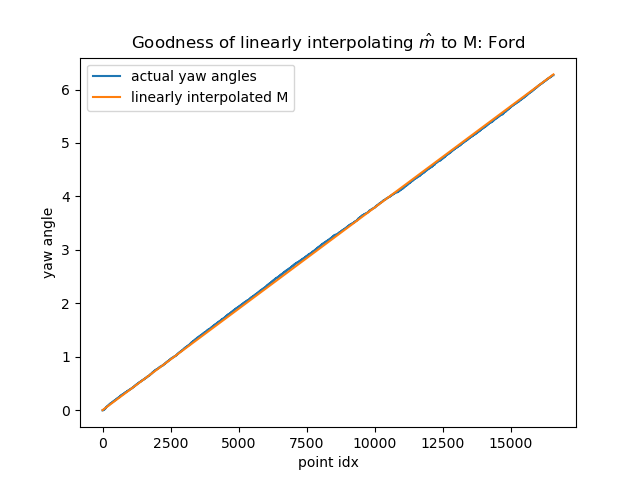

In [626]:
# print(M[::100,0])
# print(dc.cloud1_tensor)

#convert to spherical coordinates and plot theta angles-- see how evenly distributed they are for various scenes
pc1_spherical = dc.c2s(pc1)
pc2_spherical = dc.c2s(pc2)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
# yaw_angs = pc2_spherical[:,1].numpy() #has step func
# yaw_angs = (pc2_spherical[:,1] + 2*np.pi ) % (2*np.pi)  #has trouble with noise

yaw_angs = pc2_spherical[:,1].numpy()
last_subzero_idx = int(len(yaw_angs) // 8)
yaw_angs[last_subzero_idx:][yaw_angs[last_subzero_idx:] < 0.3] = yaw_angs[last_subzero_idx:][yaw_angs[last_subzero_idx:] < 0.3] + 2*np.pi

# yaw_angs = np.tan(np.arctan2(pc2_spherical[:,1].numpy(), 1))

M_naive = 2 * np.pi * np.linspace(0, len(yaw_angs)-1, len(yaw_angs)) / len(yaw_angs)

ax.set_title("Goodness of linearly interpolating $\hat{m}$ to M: Ford")
ax.set_xlabel("point idx")
ax.set_ylabel("yaw angle")
ax.plot(yaw_angs, label = "actual yaw angles")
ax.plot(M_naive, label = "linearly interpolated M")
ax.legend(loc='best')

In [424]:
st = time.time()
for i in range(100):
    dummy_pc = np.random.randn(10_0000, 3)
    ans = dc.c2s(dummy_pc)
#     print(i)
print("took", (time.time()-st)/100)

took 0.005647943019866943


# Try distortion correction on Ford Campus Datset

#### TODO: I think we need a pretty stringent moving object removal filter before estimating motion distortion in LIDAR real world point clouds

<IPython.core.display.Javascript object>


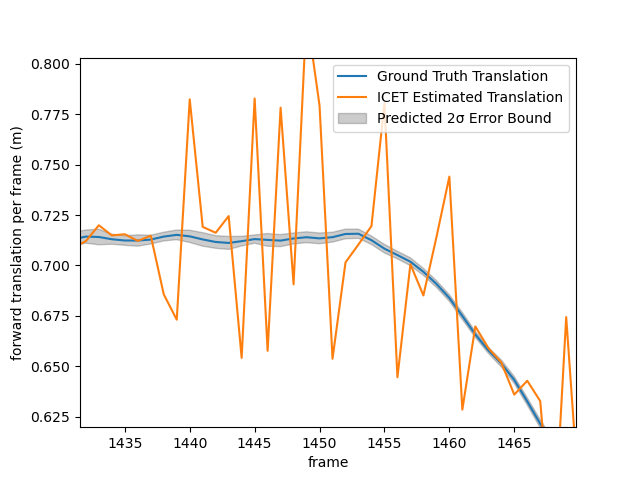

correlation: 
 [[1.         0.19497716]
 [0.19497716 1.        ]]


In [653]:
#load ICET results
estimates = np.loadtxt("../results/Ford_full_estimates_v10.txt")
pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
ground_truth = np.loadtxt("../spherical_paper/FORD_results/truth_body_frame.txt") # [0, v_xandy, v_vertical, r, p, y]
runlen = np.shape(estimates)[0]
estimates = estimates[1:,:]
no_filter = no_filter[1:,:]
pred_stds = pred_stds[1:,:]
vf = (ground_truth[:runlen-1,1]/10 + ground_truth[1:runlen,1]/10)/2 #v5

#plot ground truth vs raw ICET estimates
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(vf, label = 'Ground Truth Translation')
# print(estimates[:,0])
ax.plot(estimates[:,1], label = "ICET Estimated Translation") #was this
#NOTE-- adjust linspace here when shifting
ax.fill_between(np.linspace(0,runlen-2,runlen-1),
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'Predicted 2σ Error Bound')
ax.set_xlabel("frame")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

#correlation between higher predicted std of error and actual higher std of error
print("correlation: \n", np.corrcoef(abs(ferr), pred_stds[:,1]))

In [663]:
#load point clouds
import mat4py
#full dataset starts at 00136
# i = 1075 # correction of 0.15cm, similar error
# i = 1071 # correction of 5.0 cm, similar error
i = 1450

# i = 847

fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+75) #75 + 61 = 136
fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+76) #76 + 61 = 137

dat1 = mat4py.loadmat(fn1)
SCAN1 = dat1['SCAN']
pc1 = np.transpose(np.array(SCAN1['XYZ']))

dat2 = mat4py.loadmat(fn2)
SCAN2 = dat2['SCAN']
pc2 = np.transpose(np.array(SCAN2['XYZ']))

ground_truth = np.loadtxt("/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/FORD_DS1_truth.txt")/10
ground_truth = tf.cast(tf.convert_to_tensor(ground_truth), tf.float32)
gt = (ground_truth[i,:] + ground_truth[i+1,:])/2 #avg between pts

#flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
pc1 = np.flip(pc1, axis = 0)
pc2 = np.flip(pc2, axis = 0)
#need to rotate point clouds so the scan starts aligned with +x axis
rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
pc1 = pc1 @ rot
pc2 = pc2 @ rot
#ignore ground plane
# c1 = c1[c1[:,2] > -2.2]
# c2 = c2[c2[:,2] > -2.2] 

In [664]:
#run ICET to get initial transforms of point clouds
it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
           draw = True, group = 2, RM = True, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.6099104e-01 -1.6716404e-02  9.6929888e-04  2.3569444e-03
  1.5047207e-03 -3.1983698e-05], shape=(6,), dtype=float32)

 predicted standard deviations of error: 
 tf.Tensor(
[4.1998881e-03 5.7231734e-04 2.9658413e-04 5.5996610e-05 3.0636835e-05
 1.8084288e-04], shape=(6,), dtype=float32)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [665]:
#apply output of ICET to raw point clouds
trans = it.X[:3].numpy()
rot = R_tf(-it.X[3:]).numpy().T
pc2_transformed =  (pc2 @ rot) + trans 

In [666]:
# #for debug: inject exaggerated distortion to one of the clouds
# m_hat_distort = np.array([0., 0.,0., 0., 0., 0.])
# pc2_transformed = lc(pc2_transformed, m_hat_distort)

# plt3 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
# disp=[]
# disp.append(Points(pc1,  c = 'red'))
# # disp.append(Points(pc2[:50_000], c = 'blue')) #test to see which direction sensor is spinning
# disp.append(Points(pc2_transformed, c = 'blue'))
# plt3.show(disp, "test viz")
# ViewInteractiveWidget(plt3.window)

In [667]:
m_hat0 = np.array([0.,0, 0, 0, 0, 0])
dc = LC(cloud1 = pc1, cloud2 = pc2_transformed, fid = 50, niter = 100, draw = True, m_hat0 = m_hat0, RM = True)
ViewInteractiveWidget(dc.plt.window)

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
took 0.02597951889038086 sec  to apply motion profile
took 0.0021753311157226562 sec to get H
m_hat:  [ 3.76160583e-03 -3.14453559e-04  6.77546428e-04 -2.49479577e-04
 -1.97831196e-05  4.62823897e-04]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
took 0.02726268768310547 sec  to apply motion profile
took 0.004247188568115234 sec to get H
m_hat:  [ 5.51267713e-03 -5.69441821e-04  7.96741107e-04 -3.48283735e-04
 -3.55618831e-05  6.41822466e-04]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
took 0.027441740036010742 sec  to apply motion profile
took 0.002345561981201172 sec to get H
m_hat:  [ 6.75387494e-03 -5.95200574e-04  7.51911080e-04 -3.90809495e-04
 -4.73062792e-05  7.14157184e-04]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
took 0.02755570411682129 sec  to apply motion profile
took 0.0022895336151123047 sec to get H
m_hat:  [ 7.22622592e-03 -6.15357072e-04  6.89443666e-04 -4.12287889e-04
 -5.40266810e-05  7.36760208e-04]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
took 0.026299476623535

took 0.0287930965423584 sec  to apply motion profile
took 0.002559661865234375 sec to get H
m_hat:  [ 7.60297198e-03 -3.95198382e-04  4.82276897e-04 -4.72359796e-04
 -5.62855494e-05  7.32860062e-04]
~~~~~~~~~~~Iteration  37 ~~~~~~~~~~
took 0.027480602264404297 sec  to apply motion profile
took 0.004853248596191406 sec to get H
m_hat:  [ 7.60566676e-03 -3.95015144e-04  4.82222182e-04 -4.72370244e-04
 -5.62627829e-05  7.32807326e-04]
~~~~~~~~~~~Iteration  38 ~~~~~~~~~~
took 0.029201269149780273 sec  to apply motion profile
took 0.00228118896484375 sec to get H
m_hat:  [ 7.60544930e-03 -3.94555507e-04  4.82169562e-04 -4.72374202e-04
 -5.62641872e-05  7.32711516e-04]
~~~~~~~~~~~Iteration  39 ~~~~~~~~~~
took 0.027057647705078125 sec  to apply motion profile
took 0.0022852420806884766 sec to get H
m_hat:  [ 7.60531286e-03 -3.96075193e-04  4.82254138e-04 -4.72392829e-04
 -5.62494752e-05  7.32914777e-04]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
took 0.025952816009521484 sec  to apply motion profile


 ---checking for moving objects---
took 0.0021181106567382812 sec to get H
m_hat:  [ 0.02684704 -0.00011342  0.00316908  0.00083605 -0.00031147  0.00023059]
~~~~~~~~~~~Iteration  71 ~~~~~~~~~~
took 0.028321266174316406 sec  to apply motion profile

 ---checking for moving objects---
took 0.0022780895233154297 sec to get H
m_hat:  [ 0.0268486  -0.00011399  0.00317032  0.0008364  -0.00031158  0.00023056]
~~~~~~~~~~~Iteration  72 ~~~~~~~~~~
took 0.027896881103515625 sec  to apply motion profile

 ---checking for moving objects---
took 0.0034437179565429688 sec to get H
m_hat:  [ 0.02684884 -0.00011405  0.00317112  0.00083666 -0.00031166  0.00023051]
~~~~~~~~~~~Iteration  73 ~~~~~~~~~~
took 0.028306245803833008 sec  to apply motion profile

 ---checking for moving objects---
took 0.0022497177124023438 sec to get H
m_hat:  [ 0.02684721 -0.00011437  0.00317176  0.00083686 -0.00031174  0.00023042]
~~~~~~~~~~~Iteration  74 ~~~~~~~~~~
took 0.02952265739440918 sec  to apply motion profile

 ---

ViewInteractiveWidget(height=1376, layout=Layout(height='auto', width='100%'), width=2488)

In [668]:
print(gt.numpy())
print(it.X.numpy())

[ 0.0000000e+00  7.1343052e-01 -1.3579821e-02 -1.9629525e-03
 -1.4768480e-04  1.5356264e-04]
[ 7.6099104e-01 -1.6716404e-02  9.6929888e-04  2.3569444e-03
  1.5047207e-03 -3.1983698e-05]


# Try distortion correction on Newer College Dataset

###  As predicted, algorithm is having a trouble with cases where large swaths of the scene are missing points

In [395]:
#load data
idx = 140 #245
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + 1) + ".npy"
pc2 = np.load(fn2)

#flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
pc1 = np.flip(pc1, axis = 0)
pc2 = np.flip(pc2, axis = 0)

#run ICET to get initial transforms of point clouds
it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.01029843  0.04445003  0.00879389 -0.08896568 -0.03277177 -0.01743022], shape=(6,), dtype=float32)

 predicted standard deviations of error: 
 tf.Tensor(
[4.0132483e-04 3.1457780e-04 1.0053938e-04 1.6955746e-05 1.7919256e-05
 5.3068936e-05], shape=(6,), dtype=float32)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [396]:
#apply output of ICET to raw point clouds
trans = it.X[:3].numpy()
rot = R_tf(-it.X[3:]).numpy().T
pc2_transformed =  (pc2 @ rot) + trans 

In [397]:
#for debug: inject exaggerated distortion to one of the clouds
m_hat_distort = np.array([0., 0.,0., 0., 0., 0.])
pc2_transformed = lc(pc2_transformed, m_hat)

plt3 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(pc1,  c = 'red'))
# disp.append(Points(pc2[:15_000], c = 'blue')) #test

disp.append(Points(pc2_transformed, c = 'blue'))
plt3.show(disp, "test viz")
ViewInteractiveWidget(plt3.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [398]:
m_hat0 = np.array([0.,0, 0, 0, 0, 0])
dc = LC(cloud1 = pc1, cloud2 = pc2_transformed, fid = 50, niter = 50, draw = True, m_hat0 = m_hat0)
ViewInteractiveWidget(dc.plt.window)

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
took 0.022942304611206055 sec  to apply motion profile
took 0.0009403228759765625 sec to get H
m_hat:  [ 0.1301176  -0.23914421  0.04325202 -0.01615555 -0.02496862  0.02097084]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
took 0.020114898681640625 sec  to apply motion profile
took 0.0009779930114746094 sec to get H
m_hat:  [ 0.16938694 -0.33243483  0.07483758 -0.02787903 -0.04719122  0.03253359]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
took 0.022932052612304688 sec  to apply motion profile
took 0.002421855926513672 sec to get H
m_hat:  [ 0.17224264 -0.36227095  0.09588398 -0.0360059  -0.06208401  0.05410587]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
took 0.024536848068237305 sec  to apply motion profile
took 0.0009980201721191406 sec to get H
m_hat:  [ 0.13111465 -0.37679774  0.11096209 -0.04013221 -0.07083967  0.07253361]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
took 0.021697282791137695 sec  to apply motion profile
took 0.0010242462158203125 sec to get H
m_hat:  [ 0.04855014 -0

took 0.02490091323852539 sec  to apply motion profile
took 0.0011823177337646484 sec to get H
m_hat:  [-1.38818276 -0.10318054  0.16605738 -0.03578567 -0.05707572  0.2895481 ]
~~~~~~~~~~~Iteration  40 ~~~~~~~~~~
took 0.0231935977935791 sec  to apply motion profile
took 0.0012018680572509766 sec to get H
m_hat:  [-1.38576484 -0.10777086  0.16611774 -0.03565809 -0.05682946  0.29143021]
~~~~~~~~~~~Iteration  41 ~~~~~~~~~~
took 0.025583505630493164 sec  to apply motion profile
took 0.0014073848724365234 sec to get H
m_hat:  [-1.38836682 -0.10827941  0.16591729 -0.03553966 -0.05658916  0.29318225]
~~~~~~~~~~~Iteration  42 ~~~~~~~~~~
took 0.02259540557861328 sec  to apply motion profile
took 0.0011899471282958984 sec to get H
m_hat:  [-1.38955641 -0.10512172  0.16554862 -0.03545808 -0.05640731  0.29471484]
~~~~~~~~~~~Iteration  43 ~~~~~~~~~~
took 0.024448394775390625 sec  to apply motion profile
took 0.001239776611328125 sec to get H
m_hat:  [-1.39318442 -0.10215694  0.16524148 -0.03535714 -

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)